# Seq2seq

Implementation of seq2seq model with attention from https://www.tensorflow.org/tutorials/text/nmt_with_attention

To run this notebook : 

1.   Have the file train.lang1 and train.lang2 (aligned french-english data) in a Google Drive directory
2.   Have the wordvectors and wordvectors_wtg files from word_embeddings.ipynb in a Google Drive directory


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

#import unicodedata
import re
import numpy as np
import os
import time

In [0]:
# reproducibility
tf.random.set_seed(0)
np.random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Mounting colab with google drive
# In my Drive I have data folder containing train.lang1 and train.lang2
%cd /content/gdrive/My Drive/ift6759

/content/gdrive/My Drive/ift6759


## Preprocessing

In [0]:
# design decision included here, decided to keep é, è, ê, etc. for french 
# since otherwise it would divide a word like 'événementiel' into "v", "nementiel"

def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "é", "è", "ê", "ç", "î", "ï", "ô", "à", "û")
  w = re.sub(r"[^a-zA-Z?.!,¿éèçêîôïàû]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
fr_sentence = f"J'aime beaucoup le chocolat!"
en_sentence = f"I really like chocolate!"
print(preprocess_sentence(fr_sentence))
print(preprocess_sentence(en_sentence))

<start> j aime beaucoup le chocolat ! <end>
<start> i really like chocolate ! <end>


In [0]:
# mapping english sentences to french sentences
def combine_files(path_to_en_file, path_to_fr_file, output_path):
  with open(path_to_en_file, 'r') as en:
    with open(path_to_fr_file, 'r') as fr:
      with open(output_path, 'w') as outfile:
        en_lines = en.readlines()
        fr_lines = fr.readlines()
        for i in range(len(en_lines)):
          line = en_lines[i].strip() + '\t' + fr_lines[i]
          outfile.write(line)

In [0]:
def print_n(path_to_file, n):
  n = range(n)
  with open(path_to_file, 'r') as f:
    for i, line in enumerate(f):
      if i in n:
        print(line)

In [9]:
print('ENGLISH')
print_n('data/train.lang1', 2)

print('FRENCH')
print_n('data/train.lang2', 2)

ENGLISH
so too does the idea that accommodating religious differences is dangerous

mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be

FRENCH
L’ idée de concilier les différences religieuses semble donc dangereuse .

Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .



In [0]:
# only need to do it once, uncomment if not done
#combine_files('data/train.lang1', 'data/train.lang2', 'data/en-fr.txt')

In [10]:
# check if the combine_files function worked
print_n('data/en-fr.txt', 2)

so too does the idea that accommodating religious differences is dangerous	L’ idée de concilier les différences religieuses semble donc dangereuse .

mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be	Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .



In [0]:
# 1. Clean the sentences
# 2. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [0]:
en, fr = create_dataset('data/en-fr.txt', None)

In [13]:
# let's see what it outputs
print(en[-1])
print(fr[-1])

<start> i agree that we need an ambitious social agenda which will include combating poverty and social exclusion <end>
<start> je conviens que nous avons besoin d un agenda social ambitieux qui englobera la lutte contre la pauvreté et l exclusion sociale . <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path='data/en-fr.txt')

In [18]:
print(f"Found {len(inp_lang.word_index)} unique tokens in English")
print(f"Found {len(targ_lang.word_index)} unique tokens in French")

Found 13239 unique tokens in English
Found 16780 unique tokens in French


In [19]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
print(f"The maximum lenght of input is {max_length_inp} and the maximum length of target is {max_length_targ}.")

The maximum lenght of input is 94 and the maximum length of target is 113.


In [0]:
# Creating training and validation sets using an 90-10 split, could be modified of course
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state=6759)

In [21]:
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

9900 9900 1100 1100


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [23]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[-1])

Input Language; index to word mapping
2 ----> <start>
10 ----> that
9 ----> is
1043 ----> unacceptable
5 ----> to
61 ----> us
16 ----> on
165 ----> both
1954 ----> moral
6 ----> and
242 ----> security
97 ----> policy
2783 ----> grounds
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
18 ----> une
514 ----> telle
1222 ----> attitude
19 ----> nous
342 ----> semble
16018 ----> indéfendable
5 ----> ,
151 ----> tant
31 ----> sur
8 ----> le
358 ----> plan
4557 ----> moral
13 ----> que
31 ----> sur
8 ----> le
358 ----> plan
4 ----> de
6 ----> la
80 ----> politique
4 ----> de
136 ----> sécurité
1 ----> .
3 ----> <end>


## Model

In [0]:
# create tf.dataset and decide architecture choices
# needed to change batch size and #of units so it didn't throw out-of-memory error in colab
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 24 
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [25]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([24, 94]), TensorShape([24, 113]))

In [0]:
# Encoder with GRU gates
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # could modify the embeddings for pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (24, 94, 512)
Encoder Hidden state shape: (batch size, units) (24, 512)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [29]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (24, 512)
Attention weights shape: (batch_size, sequence_length, 1) (24, 94, 1)


In [0]:
# GRU decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [31]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (24, 16781)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
# checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [0]:
# Training steps
# 1. Pass the input through the encoder which return encoder output and the encoder hidden state.
# 2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
# 3. The decoder returns the predictions and the decoder hidden state.
# 4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
# 5. Use teacher forcing to decide the next input to the decoder.
# 6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
# 7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1737
Epoch 1 Batch 100 Loss 1.4118
Epoch 1 Batch 200 Loss 1.2433
Epoch 1 Batch 300 Loss 1.0743
Epoch 1 Batch 400 Loss 1.2302
Epoch 1 Loss 1.3073
Time taken for 1 epoch 278.2491250038147 sec

Epoch 2 Batch 0 Loss 1.1065
Epoch 2 Batch 100 Loss 1.1736
Epoch 2 Batch 200 Loss 1.4891
Epoch 2 Batch 300 Loss 1.2028
Epoch 2 Batch 400 Loss 0.9736
Epoch 2 Loss 1.1133
Time taken for 1 epoch 157.77699995040894 sec

Epoch 3 Batch 0 Loss 1.1558
Epoch 3 Batch 100 Loss 1.0555
Epoch 3 Batch 200 Loss 0.9161
Epoch 3 Batch 300 Loss 1.0650
Epoch 3 Batch 400 Loss 0.9764
Epoch 3 Loss 1.0154
Time taken for 1 epoch 156.28116106987 sec

Epoch 4 Batch 0 Loss 1.0975
Epoch 4 Batch 100 Loss 0.9382
Epoch 4 Batch 200 Loss 0.7956
Epoch 4 Batch 300 Loss 1.0140
Epoch 4 Batch 400 Loss 0.9949
Epoch 4 Loss 0.9619
Time taken for 1 epoch 156.99899339675903 sec

Epoch 5 Batch 0 Loss 0.8135
Epoch 5 Batch 100 Loss 0.8581
Epoch 5 Batch 200 Loss 0.9308
Epoch 5 Batch 300 Loss 0.8936
Epoch 5 Batch 400 Loss 0.9

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  # if input word not in input vocab, output random input word
  inputs = [inp_lang.word_index[i] if i in inp_lang.word_index else np.random.randint(low=0, high=len(inp_lang.word_index), size=1) for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()
    #print(predicted_id)

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  print(f"length of the predicted translation : {len(result.split(' '))}")

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [39]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [40]:
# last sentence of validation
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[-1])

Input Language; index to word mapping
2 ----> <start>
71 ----> europe
9 ----> is
30 ----> at
8 ----> a
6938 ----> crossroads
100 ----> just
24 ----> as
12 ----> it
35 ----> was
168 ----> after
1 ----> the
307 ----> second
108 ----> world
351 ----> war
28 ----> which
2874 ----> resulted
7 ----> in
1 ----> the
1629 ----> birth
4 ----> of
41 ----> what
35 ----> was
19 ----> not
135 ----> then
846 ----> known
24 ----> as
1 ----> the
31 ----> european
66 ----> union
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
7 ----> l
83 ----> europe
45 ----> se
473 ----> trouve
11 ----> à
369 ----> moment
3732 ----> décisif
4 ----> de
69 ----> son
520 ----> histoire
5 ----> ,
57 ----> tout
56 ----> comme
50 ----> elle
7 ----> l
93 ----> était
11 ----> à
6 ----> la
311 ----> fin
4 ----> de
6 ----> la
1494 ----> seconde
363 ----> guerre
355 ----> mondiale
5 ----> ,
510 ----> lorsqu
16 ----> est
4527 ----> née
7 ----> l
2150 ----> association
3436 ----> connue
99 ----> aujourd
100 -

Input: <start> europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union <end>
Predicted translation: l union européenne . <end> 
length of the predicted translation : 6


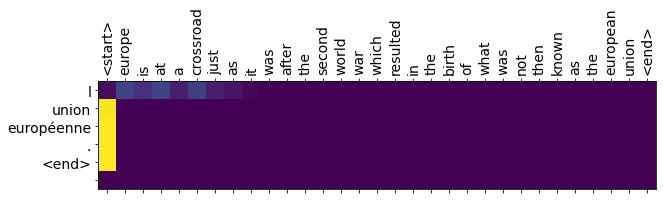

In [41]:
# trying to predict last sentence of validation set
translate(f"europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union")

In [42]:
# predicting another sentence of validation set
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[3])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[3])

Input Language; index to word mapping
2 ----> <start>
11 ----> i
188 ----> m
19 ----> not
1 ----> the
80 ----> only
52 ----> one
77 ----> who
21 ----> s
3789 ----> obsessed
23 ----> with
14 ----> this
275 ----> whole
159 ----> year
306 ----> thing
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
23 ----> je
29 ----> ne
95 ----> suis
28 ----> pas
6 ----> la
334 ----> seule
11 ----> à
42 ----> être
15078 ----> obsédée
33 ----> par
37 ----> cette
755 ----> affaire
12 ----> des
165 ----> ans
1 ----> .
3 ----> <end>


Input: <start> i m not the only one who s obsessed with this whole year thing <end>
Predicted translation: je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous 
length of the predicted translation : 114


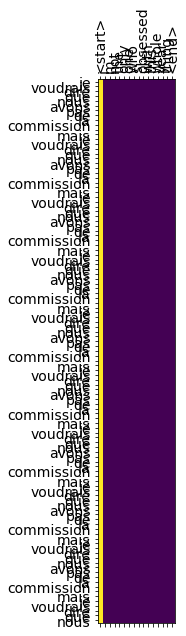

In [43]:
# Here we see some not so good behavior of the model, the lenght of the predicted translation is 114 because its max lenght is 113 and the model adds a space afterwards
translate(f"i'm not the only one who's obsessed with this whole year thing")

In [0]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[1])

Input Language; index to word mapping
2 ----> <start>
25 ----> will
63 ----> he
1949 ----> pass
1 ----> the
3402 ----> examination
11 ----> i
102 ----> am
1220 ----> afraid
19 ----> not
3 ----> <end>


Input: <start> will he pass the examination i am afraid not <end>
Predicted translation: il est pas de la commission , et les états membres . <end> 
length of the predicted translation : 14


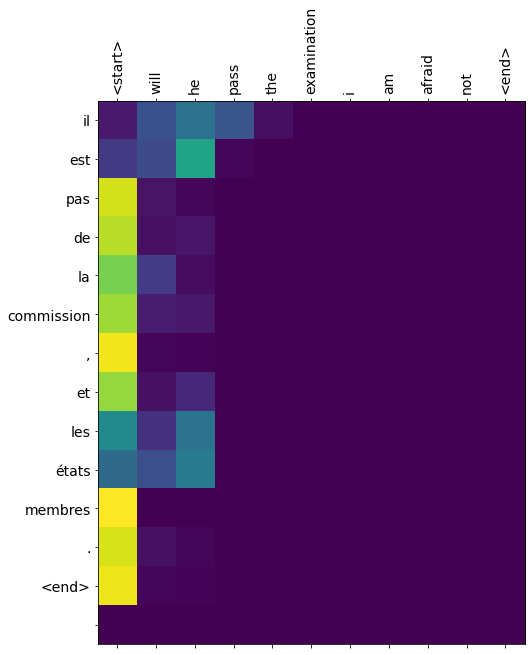

In [0]:
translate(f"will he pass the examination i am afraid not")

## Models with pre-trained word2vec embeddings

Please refer to the word_embeddings.ipynb for the code. Note that two word2vec models were trained. One where each sentence doesn't have a start and end tag and one where each sentence does.

### pre-trained word2vec embeddings (no start and end token)

In [51]:
# loading word2vec embeddings
from gensim.models import KeyedVectors
# model without tag
w2v_english = KeyedVectors.load('data/wordvectors')
w2v_french = KeyedVectors.load('data/french_wordvectors')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# embedding matrix
def create_embedding_matrix(inp_lang, embedding_dim, embedding_model):
  print('Preparing embedding matrix')
  oov = 0
  oov_words = []
  vocab_size = len(inp_lang.word_index) + 1
  word_index = inp_lang.word_index
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in word_index.items():
    if word not in embedding_model:
      # we can investigate the oov words
      oov_words.append(word)
      oov += 1
      # words not found in embedding_model will all be set to 0
      embedding_vector = np.zeros((100,))
    else:
      embedding_vector = embedding_model.get_vector(word)
    embedding_matrix[i] = embedding_vector
  print(f"Found {oov} out-of-vocabulary words (not present in the embedding model)")
  return embedding_matrix

In [28]:
embedding_matrix = create_embedding_matrix(inp_lang, embedding_dim=100, embedding_model=w2v_english)

Preparing embedding matrix
Found 435 out-of-vocabulary words (not present in the embedding model)


In [29]:
print(np.shape(embedding_matrix))

(13240, 100)


In [52]:
french_embedding_matrix = create_embedding_matrix(targ_lang, embedding_dim=100, embedding_model=w2v_french)

Preparing embedding matrix
Found 668 out-of-vocabulary words (not present in the embedding model)


In [53]:
print(np.shape(french_embedding_matrix))

(16781, 100)


In [0]:
# Encoder with GRU gates and pre-trained embedding with word2vec without start and end token
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embedding_matrix):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # could modify the embeddings for pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [35]:
# specify the embedding dim to be equal to the embedding dim chosen for word embeddings
embedding_dim = 100
vocab_inp_size = len(inp_lang.word_index)+1
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, embedding_matrix)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (24, 94, 512)
Encoder Hidden state shape: (batch size, units) (24, 512)


In [40]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (24, 512)
Attention weights shape: (batch_size, sequence_length, 1) (24, 94, 1)


In [0]:
# GRU decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    # Here we specify the pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[french_embedding_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [56]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (24, 16781)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
# checkpoints do not want to override previous model
checkpoint_dir_w2v = './training_checkpoints_word2vec'
checkpoint_prefix = os.path.join(checkpoint_dir_w2v, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [61]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7494
Epoch 1 Batch 100 Loss 1.2133
Epoch 1 Batch 200 Loss 0.8494
Epoch 1 Batch 300 Loss 1.1852
Epoch 1 Batch 400 Loss 0.8876
Epoch 1 Loss 1.1691
Time taken for 1 epoch 259.0653929710388 sec

Epoch 2 Batch 0 Loss 0.9291
Epoch 2 Batch 100 Loss 0.9233
Epoch 2 Batch 200 Loss 0.9167
Epoch 2 Batch 300 Loss 1.0230
Epoch 2 Batch 400 Loss 0.9295
Epoch 2 Loss 0.9484
Time taken for 1 epoch 139.60873818397522 sec

Epoch 3 Batch 0 Loss 0.6911
Epoch 3 Batch 100 Loss 0.9318
Epoch 3 Batch 200 Loss 1.0349
Epoch 3 Batch 300 Loss 1.0104
Epoch 3 Batch 400 Loss 0.7851
Epoch 3 Loss 0.8492
Time taken for 1 epoch 139.2361297607422 sec

Epoch 4 Batch 0 Loss 0.5827
Epoch 4 Batch 100 Loss 0.7439
Epoch 4 Batch 200 Loss 0.7491
Epoch 4 Batch 300 Loss 0.7972
Epoch 4 Batch 400 Loss 0.9051
Epoch 4 Loss 0.7623
Time taken for 1 epoch 140.0453760623932 sec

Epoch 5 Batch 0 Loss 0.7580
Epoch 5 Batch 100 Loss 0.7179
Epoch 5 Batch 200 Loss 0.5218
Epoch 5 Batch 300 Loss 0.8019
Epoch 5 Batch 400 Loss 0.

Here we load the previously trained GRU with attention with pre-trained embeddings without start and end tag.

In [63]:
# compared to predicting first sentence of validation set with word2vec model (without <start> and <end> for each sentence)

# checkpoints
checkpoint_dir_w2v = './training_checkpoints_word2vec'
checkpoint_prefix = os.path.join(checkpoint_dir_w2v, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_w2v))

Input: <start> europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union <end>
Predicted translation: l europe est un seul exemple comme l heure actuelle , le plus grande surprise que le monde , <end> 
length of the predicted translation : 21


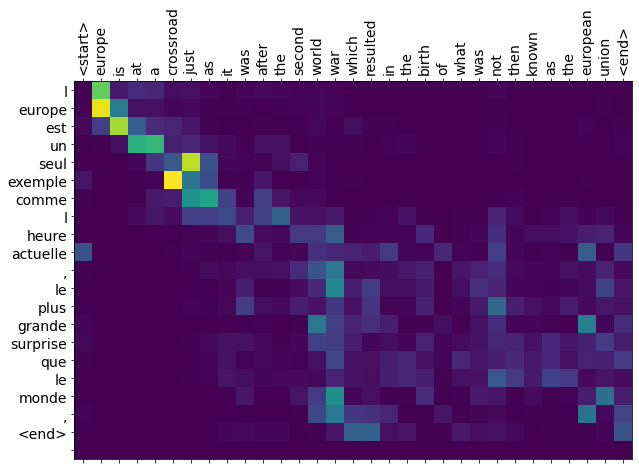

In [67]:
translate(f"europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union")

Input: <start> i m not the only one who s obsessed with this whole year thing <end>
Predicted translation: je n enfreins pas seulement le seul qui a quelque chose qui se trouve avec ce genre de ce genre . <end> 
length of the predicted translation : 23


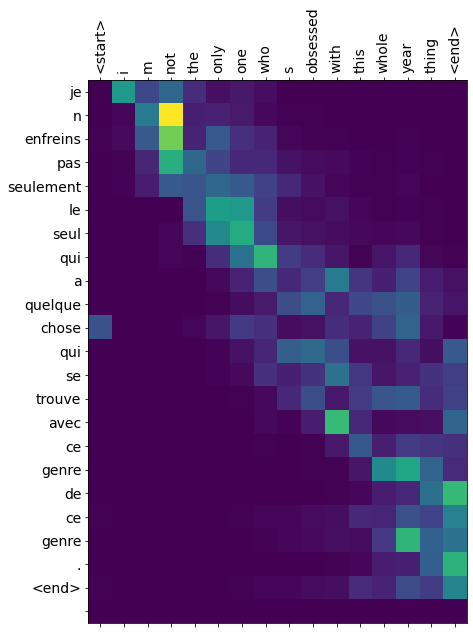

In [68]:
translate(f"i'm not the only one who's obsessed with this whole year thing")

Input: <start> will he pass the examination i am afraid not <end>
Predicted translation: il est parti de la proposition , je ne me pas ? <end> 
length of the predicted translation : 14


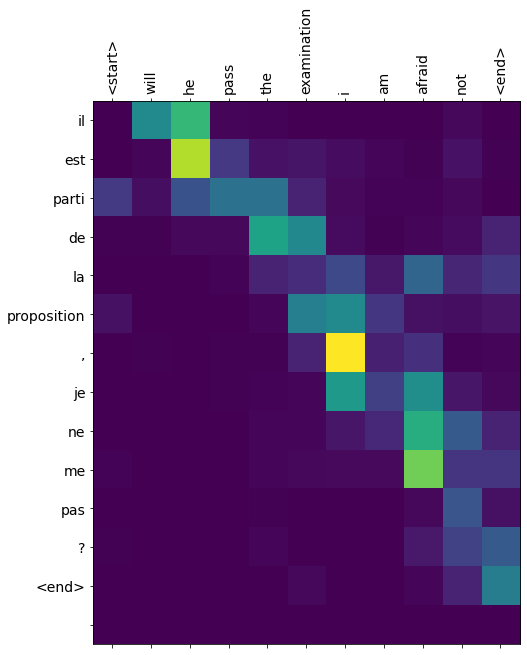

In [69]:
translate(f"will he pass the examination i am afraid not")

### pre-trained word2vec embeddings with start and end tag.

In [94]:
# model with tag
w2v_english_wtag = KeyedVectors.load('data/wordvectors_wtag')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [95]:
embedding_matrix_wtg = create_embedding_matrix(inp_lang, embedding_dim=100, embedding_model=w2v_english_wtag)

Preparing embedding matrix
Found 433 out-of-vocabulary words (not present in the embedding model)


In [0]:
# Encoder with GRU gates and pre-trained embedding with word2vec without start and end token
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embedding_matrix):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # could modify the embeddings for pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix_wtg], trainable=False)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [97]:
# specify the embedding dim to be equal to the embedding dim chosen for word embeddings
embedding_dim = 100
vocab_inp_size = len(inp_lang.word_index)+1
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, embedding_matrix_wtg)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (24, 94, 512)
Encoder Hidden state shape: (batch size, units) (24, 512)


In [98]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (24, 512)
Attention weights shape: (batch_size, sequence_length, 1) (24, 94, 1)


In [99]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (24, 16781)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
# checkpoints do not want to override previous model
checkpoint_dir_w2v_wtg = './training_checkpoints_word2vec_wtg'
checkpoint_prefix = os.path.join(checkpoint_dir_w2v_wtg, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [103]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9939
Epoch 1 Batch 100 Loss 1.3583
Epoch 1 Batch 200 Loss 1.3191
Epoch 1 Batch 300 Loss 1.1664
Epoch 1 Batch 400 Loss 1.1638
Epoch 1 Loss 1.2820
Time taken for 1 epoch 258.0109508037567 sec

Epoch 2 Batch 0 Loss 1.0469
Epoch 2 Batch 100 Loss 1.0140
Epoch 2 Batch 200 Loss 1.1356
Epoch 2 Batch 300 Loss 1.2557
Epoch 2 Batch 400 Loss 1.1684
Epoch 2 Loss 1.0832
Time taken for 1 epoch 139.75686192512512 sec

Epoch 3 Batch 0 Loss 1.0625
Epoch 3 Batch 100 Loss 0.8479
Epoch 3 Batch 200 Loss 1.0465
Epoch 3 Batch 300 Loss 1.2973
Epoch 3 Batch 400 Loss 0.9463
Epoch 3 Loss 0.9955
Time taken for 1 epoch 138.82635688781738 sec

Epoch 4 Batch 0 Loss 1.0755
Epoch 4 Batch 100 Loss 0.9934
Epoch 4 Batch 200 Loss 0.9167
Epoch 4 Batch 300 Loss 0.6764
Epoch 4 Batch 400 Loss 0.8040
Epoch 4 Loss 0.9229
Time taken for 1 epoch 139.39134454727173 sec

Epoch 5 Batch 0 Loss 0.8911
Epoch 5 Batch 100 Loss 1.0606
Epoch 5 Batch 200 Loss 0.8014
Epoch 5 Batch 300 Loss 1.0307
Epoch 5 Batch 400 Loss 

In [104]:
# checkpoints
checkpoint_dir_w2v_wtg = './training_checkpoints_word2vec_wtg'
checkpoint_prefix = os.path.join(checkpoint_dir_w2v_wtg, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_w2v_wtg))

Input: <start> europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union <end>
Predicted translation: l europe est une seule , il n a pas été le plus important que l union européenne . <end> 
length of the predicted translation : 21


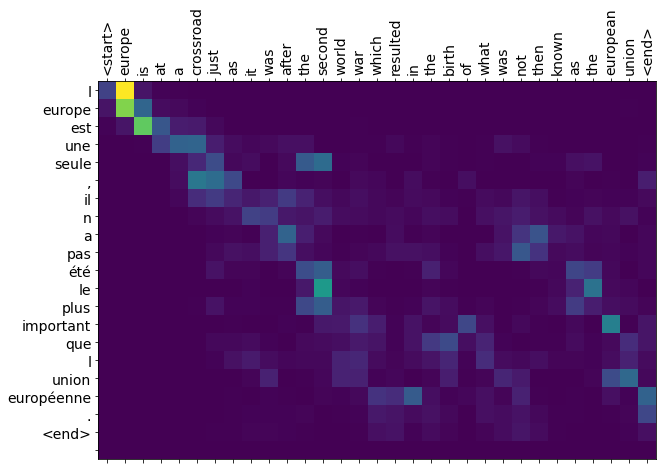

In [106]:
# trying to predict first sentence of validation set with word2vec_wtg model
translate(f"europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union")

Input: <start> i m not the only one who s obsessed with this whole year thing <end>
Predicted translation: je ne suis pas seulement une seule chose . <end> 
length of the predicted translation : 11


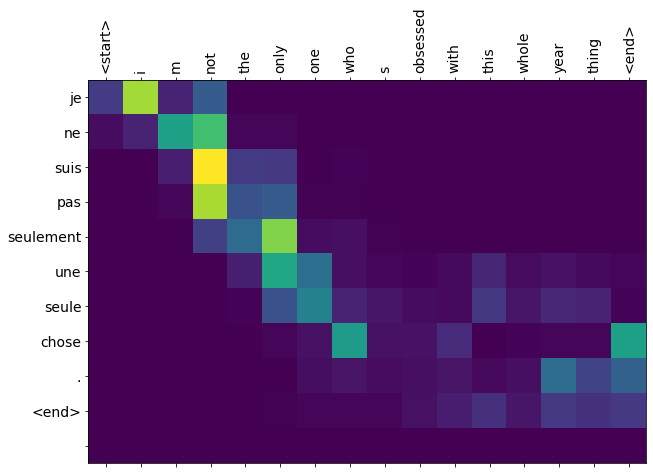

In [107]:
translate(f"i'm not the only one who's obsessed with this whole year thing")

Input: <start> will he pass the examination i am afraid not <end>
Predicted translation: devra il prendre note ? <end> 
length of the predicted translation : 7


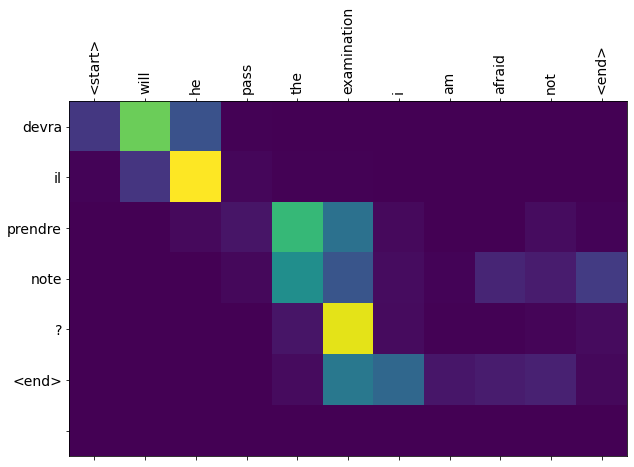

In [108]:
translate(f"will he pass the examination i am afraid not")

## Models with pre-trained FastText embeddings

### pre-trained FastText embeddings (no start and end token)

In [109]:
# loading fastText embeddings
from gensim.models import KeyedVectors
# model without tag
fasttext_english = KeyedVectors.load('data/fasttext_wordvectors')
fasttext_french = KeyedVectors.load('data/fasttext_french_wordvectors')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [110]:
# english embedding matrix for fasttext
ft_en_embedding_matrix = create_embedding_matrix(inp_lang, embedding_dim=100, embedding_model=fasttext_english)

print(np.shape(ft_en_embedding_matrix))

Preparing embedding matrix
Found 2 out-of-vocabulary words (not present in the embedding model)


In [113]:
ft_fr_embedding_matrix = create_embedding_matrix(targ_lang, embedding_dim=100, embedding_model=fasttext_french)

print(np.shape(ft_fr_embedding_matrix))

Preparing embedding matrix
Found 4 out-of-vocabulary words (not present in the embedding model)
(16781, 100)


In [0]:
# Encoder with GRU gates and pre-trained embedding with word2vec without start and end token
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embedding_matrix):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # could modify the embeddings for pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[ft_en_embedding_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [115]:
# specify the embedding dim to be equal to the embedding dim chosen for word embeddings
embedding_dim = 100
vocab_inp_size = len(inp_lang.word_index)+1
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, ft_en_embedding_matrix)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (24, 94, 512)
Encoder Hidden state shape: (batch size, units) (24, 512)


In [116]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (24, 512)
Attention weights shape: (batch_size, sequence_length, 1) (24, 94, 1)


In [0]:
# GRU decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    # Here we specify the pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[ft_fr_embedding_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [118]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (24, 16781)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
# checkpoints do not want to override previous model
checkpoint_dir_ft = './training_checkpoints_fasttext'
checkpoint_prefix = os.path.join(checkpoint_dir_ft, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [122]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2530
Epoch 1 Batch 100 Loss 1.2381
Epoch 1 Batch 200 Loss 0.9874
Epoch 1 Batch 300 Loss 0.9048
Epoch 1 Batch 400 Loss 0.9285
Epoch 1 Loss 1.1769
Time taken for 1 epoch 256.83527517318726 sec

Epoch 2 Batch 0 Loss 0.8669
Epoch 2 Batch 100 Loss 0.9540
Epoch 2 Batch 200 Loss 0.8572
Epoch 2 Batch 300 Loss 1.0422
Epoch 2 Batch 400 Loss 0.9373
Epoch 2 Loss 0.9945
Time taken for 1 epoch 139.23003315925598 sec

Epoch 3 Batch 0 Loss 0.8121
Epoch 3 Batch 100 Loss 1.0457
Epoch 3 Batch 200 Loss 0.9419
Epoch 3 Batch 300 Loss 0.8934
Epoch 3 Batch 400 Loss 0.8975
Epoch 3 Loss 0.9144
Time taken for 1 epoch 138.9230124950409 sec

Epoch 4 Batch 0 Loss 1.0459
Epoch 4 Batch 100 Loss 0.7864
Epoch 4 Batch 200 Loss 1.0072
Epoch 4 Batch 300 Loss 0.8839
Epoch 4 Batch 400 Loss 0.9448
Epoch 4 Loss 0.8436
Time taken for 1 epoch 139.30845141410828 sec

Epoch 5 Batch 0 Loss 0.8629
Epoch 5 Batch 100 Loss 0.7522
Epoch 5 Batch 200 Loss 0.7946
Epoch 5 Batch 300 Loss 0.7246
Epoch 5 Batch 400 Loss 

In [123]:
# checkpoints
checkpoint_dir_ft = './training_checkpoints_fasttext'
checkpoint_prefix = os.path.join(checkpoint_dir_ft, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_ft))

Input: <start> europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union <end>
Predicted translation: l europe est une chose qui , comme l on rassasiera l o o o est pas de l union européenne . <end> 
length of the predicted translation : 24


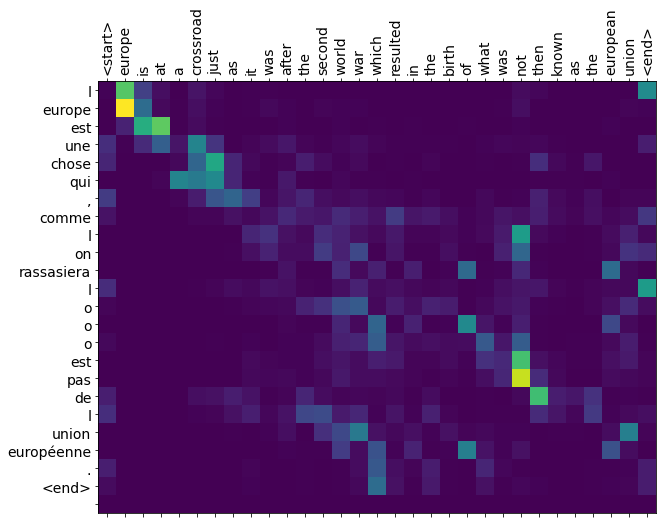

In [124]:
translate(f"europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union")

Input: <start> i m not the only one who s obsessed with this whole year thing <end>
Predicted translation: je ne suis pas la seule personne qui se trouve avec cette nouvelle fois . <end> 
length of the predicted translation : 17


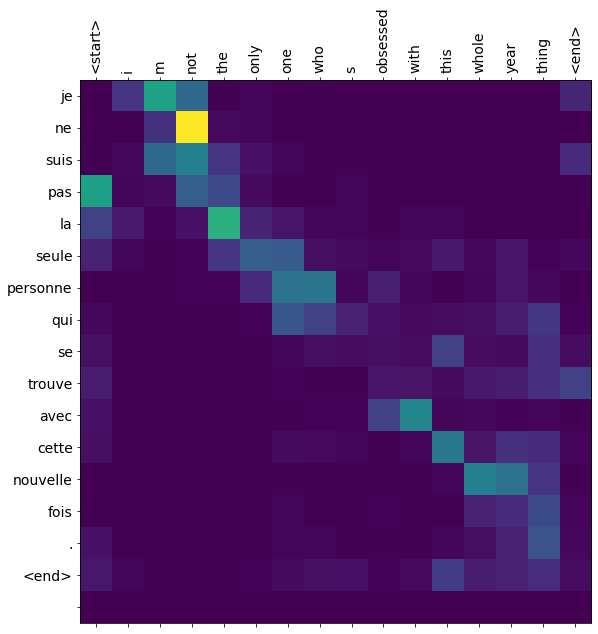

In [125]:
translate(f"i'm not the only one who's obsessed with this whole year thing")

Input: <start> will he pass the examination i am afraid not <end>
Predicted translation: il ne peux pas dire . je ne suis pas . <end> 
length of the predicted translation : 13


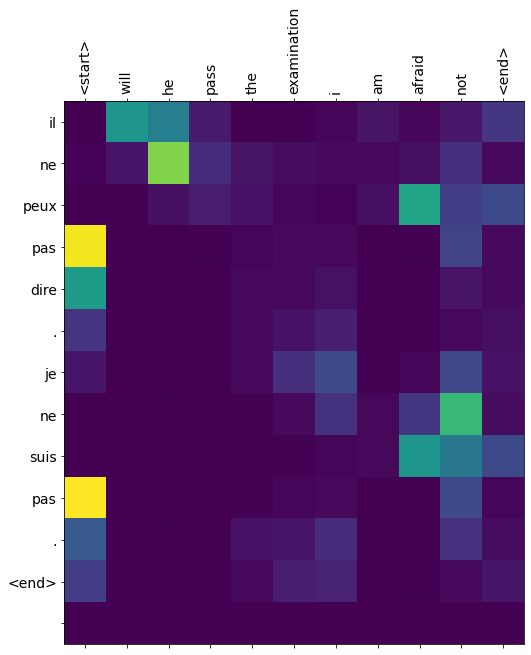

In [126]:
translate(f"will he pass the examination i am afraid not")

### pre-trained FastText embeddings with start and end token

In [128]:
# loading fastText embeddings
from gensim.models import KeyedVectors

fasttext_english_wtg = KeyedVectors.load('data/fasttext_wordvectors_wtag')
fasttext_french = KeyedVectors.load('data/fasttext_french_wordvectors')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [129]:
ft_en_embedding_matrix_wtg = create_embedding_matrix(inp_lang, embedding_dim=100, embedding_model=fasttext_english_wtg)

Preparing embedding matrix
Found 2 out-of-vocabulary words (not present in the embedding model)


In [0]:
# Encoder with GRU gates and pre-trained embedding with word2vec without start and end token
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embedding_matrix):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # could modify the embeddings for pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[ft_en_embedding_matrix_wtg], trainable=False)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [131]:
# specify the embedding dim to be equal to the embedding dim chosen for word embeddings
embedding_dim = 100
vocab_inp_size = len(inp_lang.word_index)+1
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, ft_en_embedding_matrix_wtg)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (24, 94, 512)
Encoder Hidden state shape: (batch size, units) (24, 512)


In [132]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (24, 512)
Attention weights shape: (batch_size, sequence_length, 1) (24, 94, 1)


In [0]:
# GRU decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    # Here we specify the pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[ft_fr_embedding_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [135]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (24, 16781)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
# checkpoints do not want to override previous model
checkpoint_dir_ft_wtg = './training_checkpoints_fasttext_wtg'
checkpoint_prefix = os.path.join(checkpoint_dir_ft_wtg, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [139]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0194
Epoch 1 Batch 100 Loss 1.2437
Epoch 1 Batch 200 Loss 1.0798
Epoch 1 Batch 300 Loss 1.1100
Epoch 1 Batch 400 Loss 1.4164
Epoch 1 Loss 1.1830
Time taken for 1 epoch 261.59091663360596 sec

Epoch 2 Batch 0 Loss 0.8752
Epoch 2 Batch 100 Loss 0.9979
Epoch 2 Batch 200 Loss 0.8763
Epoch 2 Batch 300 Loss 0.8445
Epoch 2 Batch 400 Loss 0.9131
Epoch 2 Loss 0.9948
Time taken for 1 epoch 139.41678595542908 sec

Epoch 3 Batch 0 Loss 1.1747
Epoch 3 Batch 100 Loss 1.0096
Epoch 3 Batch 200 Loss 1.0119
Epoch 3 Batch 300 Loss 0.8927
Epoch 3 Batch 400 Loss 0.8483
Epoch 3 Loss 0.9133
Time taken for 1 epoch 138.93417859077454 sec

Epoch 4 Batch 0 Loss 0.8726
Epoch 4 Batch 100 Loss 0.8994
Epoch 4 Batch 200 Loss 0.7136
Epoch 4 Batch 300 Loss 0.9682
Epoch 4 Batch 400 Loss 0.7378
Epoch 4 Loss 0.8455
Time taken for 1 epoch 139.52025938034058 sec

Epoch 5 Batch 0 Loss 0.8444
Epoch 5 Batch 100 Loss 0.7684
Epoch 5 Batch 200 Loss 0.6334
Epoch 5 Batch 300 Loss 0.7939
Epoch 5 Batch 400 Loss

In [140]:
# checkpoints
checkpoint_dir_ft_wtg = './training_checkpoints_fasttext_wtg'
checkpoint_prefix = os.path.join(checkpoint_dir_ft_wtg, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_ft_wtg))

Input: <start> europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union <end>
Predicted translation: l europe est en fait , le début de la zone euro , qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . qui n était pas seulement comme le monde entier . 
length of the predicted translation : 114


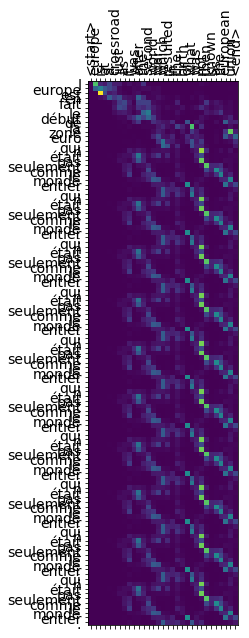

In [141]:
translate(f"europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union")

Input: <start> i m not the only one who s obsessed with this whole year thing <end>
Predicted translation: je n ai pas la seule personne qui est de cette assemblée . <end> 
length of the predicted translation : 15


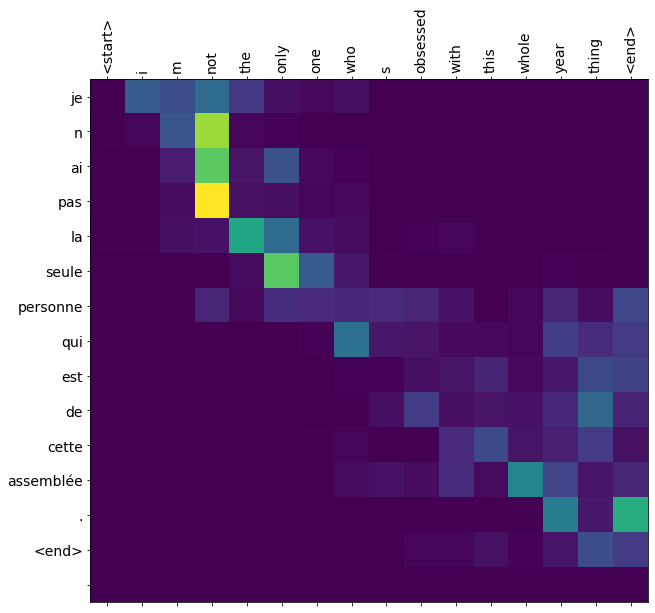

In [142]:
translate(f"i'm not the only one who's obsessed with this whole year thing")

Input: <start> will he pass the examination i am afraid not <end>
Predicted translation: il n est pas , <end> 
length of the predicted translation : 7


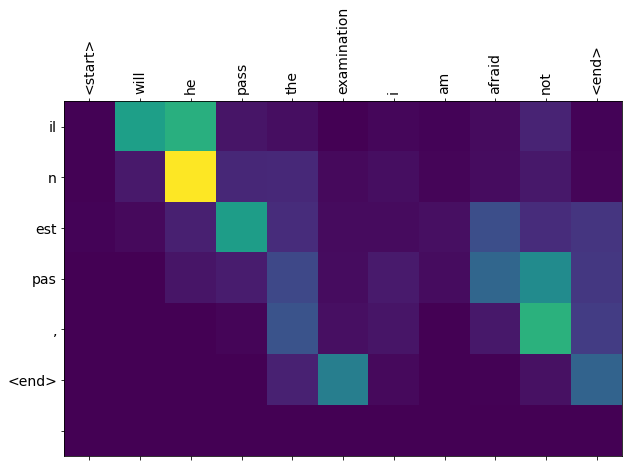

In [143]:
translate(f"will he pass the examination i am afraid not")

## Evaluation

In [0]:
# used to map indices of target tensor to the aligned train.lang2 file 
# so we don't lose which original sentence from the aligned files is in train and test
import pandas as pd
target_df = pd.DataFrame(target_tensor)
input_df = pd.DataFrame(input_tensor)

input_df_train, input_df_val, target_df_train, target_df_val = train_test_split(input_df, target_df, test_size=0.1, random_state=6759)

In [0]:
#indices = [x + 1 for x in list(target_df_val.index)]
indices = list(target_df_val.index)

In [0]:
# indicies of english test set
indices_en = list(input_df_val.index)

In [48]:
indices_en_train = list(input_df_train.index)

9900

In [0]:
# need to change this function so it doesn't really on anything else before that is not in the function itself
def target_to_file(input_path, output_path, indices):
  """ Function that writes only the sentences used in the train-test split to a file so it can be used to write targets.txt for evaluator.py or the input to write_prediction_file """
  with open(input_path, 'r') as f:
    with open(output_path, 'w') as outfile:
      for index, line in enumerate(f):
        if index in indices:
          line = line.strip() + "\n"
          outfile.write(line)

In [0]:
# creates input_en.txt (used in the generate_predictions function) which are the test sentences to be translated
# only need to do it once, uncomment if not done
# target_to_file('data/train.lang1', 'data/input_en.txt', indices_en)

In [0]:
# training set
target_to_file('data/train.lang1', 'data/train_en.txt', indices_en_train)

In [0]:
# creates targets.txt which are true translation from english to french
# only need to do it once, uncomment if not done
# target_to_file('data/train.lang2', 'data/targets.txt', indices)

In [0]:
# need to add docstring to function
def generate_predictions(input_lang_file, prediction_file_path, model):
  # base doesn't work, throw out an error with shapes
  if model == 'base':
    checkpoint_dir = './training_checkpoints'
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  elif model == 'word2vec':
    checkpoint_dir_w2v = './training_checkpoints_word2vec'
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_w2v))
  elif model == 'word2vec_wtg':
    checkpoint_dir_w2v_wtg = './training_checkpoints_word2vec_wtg'
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_w2v_wtg))
  elif model == 'fasttext':
    checkpoint_dir_ft = './training_checkpoints_fasttext'
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_ft))
  elif model == 'fasttext_wtg':
    checkpoint_dir_ft_wtg = './training_checkpoints_fasttext_wtg'
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_ft_wtg))
  else:
    raise ValueError('model name not recognized')

  with open(input_lang_file, 'r') as f:
    with open(prediction_file_path, 'w') as outfile:
      for index, sentence in enumerate(f):
        sent = preprocess_sentence(sentence)
        
        inputs = [inp_lang.word_index[i] if i in inp_lang.word_index else np.random.randint(low=0, high=len(inp_lang.word_index), size=1) for i in sent.split(' ')]
        inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
        inputs = tf.convert_to_tensor(inputs)
        result = ''
        hidden = [tf.zeros((1, units))]
        enc_out, enc_hidden = encoder(inputs, hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
        sentence_list = []

        for t in range(max_length_targ):
          predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
          predicted_id = tf.argmax(predictions[0]).numpy()
          result = targ_lang.index_word[predicted_id]
          sentence_list.append(result)
          if targ_lang.index_word[predicted_id] == '<end>':
              break
          # the predicted ID is fed back into the model
          dec_input = tf.expand_dims([predicted_id], 0)

        if "<end>" in sentence_list:
          sentence_list.remove("<end>")
        outfile.write(' '.join([str(word) for word in sentence_list]) + "\n")

In [0]:
# only need to do it once per model, uncomment if not done
generate_predictions('data/input_en.txt', 'data/predictions_word2vec.txt', 'word2vec')

In [0]:
%cd /content/gdrive/My Drive/ift6759/code

/content/gdrive/My Drive/ift6759/code


In [0]:
!python evaluator.py --input-file-path predictions.txt --target-file-path targets.txt --do-not-run-model

Traceback (most recent call last):
  File "evaluator.py", line 64, in <module>
    main()
  File "evaluator.py", line 56, in main
    compute_bleu(args.input_file_path, args.target_file_path, args.print_all_scores)
  File "evaluator.py", line 33, in compute_bleu
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
  File "/usr/lib/python3.6/subprocess.py", line 423, in run
    with Popen(*popenargs, **kwargs) as process:
TypeError: __init__() got an unexpected keyword argument 'text'
